# Fine-tune LayoutLMv3 for token classification on LETTERS dataset

## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [ ]:
!pip install -q datasets seqeval transformers
!pip install transformers accelerate

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/cord-layoutlmv3). This one is the [CORD](https://github.com/clovaai/cord) dataset, a collection of annotated receipts.  

Loading this dataset can take 10 minutes. The generating train split takes a bit.

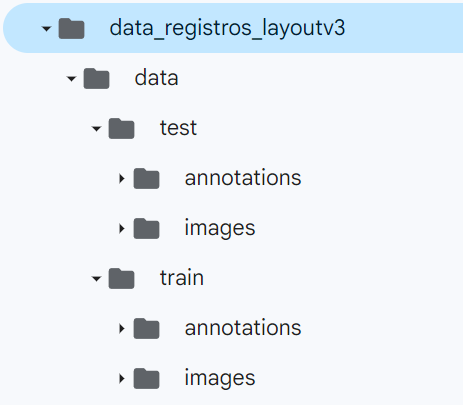

In [ ]:
from datasets import load_dataset

#dataset = load_dataset('/content/drive/MyDrive/data_cartas_layoutv3',data_dir='/content/drive/MyDrive/data_cartas_layoutv3') #letters
dataset = load_dataset('/content/drive/MyDrive/data_registros_layoutv3',data_dir='/content/drive/MyDrive/data_registros_layoutv3') #registros
#dataset = load_dataset('/content/drive/MyDrive/layout_v1_pres', data_dir='/content/drive/MyDrive/layout_v1_pres')
#dataset = load_dataset('/content/drive/MyDrive/data_cedulas_layoutv3',data_dir='/content/drive/MyDrive/data_cedulas_layoutv3') #letters

#dataset = load_dataset('data',data_dir='data')
dataset

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [ ]:
from transformers import AutoProcessor
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [ ]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

def unnormalize_box(bbox, width, height):
     return [
         int(width * (bbox[0] / 1000)),
         int(height * (bbox[1] / 1000)),
         int(width * (bbox[2] / 1000)),
         int(height * (bbox[3] / 1000))
     ]
if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

Next, we'll define a function which we can apply on the entire dataset.


In [ ]:
from PIL import Image
def prepare_examples(examples):
  images=[]
  for im in examples[image_column_name]:
    print("pat",im)
    images.append(Image.open(im).convert("RGB")) ##if you use an image path, this will need to be updated to read the image in

  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

In [ ]:
##I used this code to subset the data for building learning curves,
# you will probably ignore this and train on all the data
train_sample = dataset["train"].shuffle(seed=42)
test_sample = dataset["test"].shuffle(seed=42)
#train_sample = dataset["train"].select(range(300))


train_dataset = train_sample.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

In [ ]:
print(train_dataset)
print(eval_dataset)
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

Next, we set the format to PyTorch.

In [ ]:
train_dataset.set_format("torch")

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.
The training arguments I set here:
- max steps for how long I thought it would take to train - you may need more steps
- batch_size was tweaked based on GPU memory
- push to hub was set to save my model to the hugging face hub
- evaluation strategy, steps was set to periodically evaluate the model
- metric for best model was to save the best checkpoint model based on accuracy

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutlmv3-finetuned-registros_v2",
                                  max_steps=1000,#2500
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  push_to_hub=True,  # after training, we'd like to push our model to the hub
                                  push_to_hub_model_id=f"layoutlmv3-finetuned-registros_v2",
                                  learning_rate=0.5e-5, #-5 original
                                  evaluation_strategy="steps",
                                  eval_steps=250,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy")

We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

## Train the model

Let's train!

In [ ]:
trainer.train()

Evaluación del modelo

In [ ]:
trainer.evaluate()

Para guardar el modelo en mi cuenta de hugging face

In [ ]:
trainer.push_to_hub("layoutlmv3-finetuned-letters_v3")

Para guardarlo en drive

In [ ]:
#guardo el modelo
model_dir = '/content/drive/My Drive/models/'
model.save_pretrained(model_dir + 'layoutv3_registros_v3')

# Inference #

This section loads the model from the hub and does not assume we have just trained the model. This is a realistic scenario for me, as Google Colab often makes me use multiple sessions.

In [ ]:
#model = AutoModelForTokenClassification.from_pretrained("/content/modelo)
from transformers import LayoutLMv3Tokenizer, LayoutLMForTokenClassification,AutoModelForTokenClassification, AutoProcessor,LayoutLMTokenizer
import torch


model_dir = '/content/drive/My Drive/models/'
#tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = LayoutLMForTokenClassification.from_pretrained(model_dir + 'layoutv3_letter_30e_gt')
#model = AutoModelForTokenClassification.from_pretrained(model_dir + "layoutv3_cedulas_v3")# )
model = AutoModelForTokenClassification.from_pretrained(model_dir + "layoutv3_letters_v4")
model = AutoModelForTokenClassification.from_pretrained(model_dir + "layoutv3_registros_v3")

model.to(device)

Constructs a LayoutLMv3 processor which combines a LayoutLMv3 image processor and a LayoutLMv3 tokenizer into a
single processor.

[LayoutLMv3Processor] offers all the functionalities you need to prepare data for the model.

It first uses [LayoutLMv3ImageProcessor] to resize and normalize document images, and optionally applies OCR to
get words and normalized bounding boxes. These are then provided to [LayoutLMv3Tokenizer] or
[LayoutLMv3TokenizerFast], which turns the words and bounding boxes into token-level input_ids,
attention_mask, token_type_ids, bbox. Optionally, one can provide integer word_labels, which are turned
into token-level labels for token classification tasks (such as FUNSD, CORD).

Args:
    image_processor (LayoutLMv3ImageProcessor):
        An instance of [LayoutLMv3ImageProcessor]. The image processor is a required input.
    tokenizer (LayoutLMv3Tokenizer or LayoutLMv3TokenizerFast):
        An instance of [LayoutLMv3Tokenizer] or [LayoutLMv3TokenizerFast

In [ ]:
import json
#from transformers import LayoutLMv3Processor
from datasets.features import ClassLabel
from PIL import Image
import time

def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]
def bbox_normalize(box, width, length):
    return (
        max(min(int(1000 * (box[0] / width)), 1000), 0),
        max(min(int(1000 * (box[1] / length)), 1000), 0),
        max(min(int(1000 * (box[2] / width)), 1000), 0),
        max(min(int(1000 * (box[3] / length)), 1000), 0)
    )

def get_features(json_data, lab_map):
    tx = []
    box2 = []
    box4 = []
    ind=[]
    w = json_data['pages'][0]['width']
    h = json_data['pages'][0]['height']
    ner_tags =[]
    try:
        for wd in json_data['pages'][0]['blocks']:
            for t in wd['paragraphs']:
                for p in t['words']:
                    tx1 = ''
                    for s in p['symbols']:
                        tx1 = tx1+s['text']
                    tx.append(tx1)
                    b = p['boundingBox']['vertices']
                    ind.append(p['index'])
                    box1 = [b[0]['x'], b[1]['y'], b[2]['x'], b[3]['y']]
                    bx = bbox_normalize(box1, w, h)
                    box2.append(bx)
                    box4.append(box1)
    except KeyError:
        for wd in json_data['pages'][0]['blocks'][0]['paragraphs'][0]['words']:
            tx.append(wd['text'])
            box1 = [int(wd['boundingBox']['vertices'][0]['x']), int(wd['boundingBox']['vertices'][1]['y']), int(wd['boundingBox']['vertices'][2]['x']), int(wd['boundingBox']['vertices'][3]['y']) ]
            bx = bbox_normalize(box1, w, h)
            box2.append(bx)
            box4.append(box1)
    for i in range(0, len(tx), 1):
        ner_tags.append(lab_map['O'])
    return tx, box2, ner_tags, box4, ind

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
print(dataset['test']['image_path'])
example = dataset["test"][29]#---------------------------------------------------------------------------------------------
image = Image.open(example['image_path'])
label_map2 = {'B-PVNR_DATE': 0, 'B-PVNR_ENT': 1, 'B-PVNR_IDE': 2, 'B-PVNR_IDP': 3, 'B-PVNR_IDTP': 4, 'B-PVNR_PER': 5, 'B-PVNR_WIA': 6, 'B-PVNR_WIC': 7, 'B-PVNR_WIT': 8, 'I-PVNR_DATE': 9, 'I-PVNR_ENT': 10, 'I-PVNR_IDE': 11, 'I-PVNR_IDTP': 12, 'I-PVNR_PER': 13, 'I-PVNR_WIA': 14, 'I-PVNR_WIC': 15, 'I-PVNR_WIT': 16, 'O': 17}
f = open('/content/drive/MyDrive/data_cartas_layoutv3/data/test/annotations/zz_1.json')
#f = open('/content/1 (5).json')
json_data = json.load(f)
f.close()

tx, box3, nt , box6, ind = get_features(json_data, label_map2)
encoded_inputs = processor(image, example['words'], boxes=example['bboxes'], word_labels=example['ner_tags'],
                           padding="max_length", truncation=True, return_tensors="pt")
#encoded_inputs = processor(image, tx, boxes=box3, word_labels=nt,
 #                          padding="max_length", truncation=True, return_tensors="pt")
token_boxes = encoded_inputs.bbox.squeeze().tolist()
box_ant= [0,0,0,0]
labels = []
for bx in token_boxes:
  if bx != [0,0,0,0] and bx != box_ant:
    labels.append(27)
    box_ant=bx
  else:
    labels.append(-100)
    box_ant=bx
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)
labels = encoded_inputs.pop('labels').squeeze().tolist() #los labels los haría así, pero por el problema lo haré a mano

st = time.time()
outputs = model(**encoded_inputs)
fin=time.time()
print("EXECUTION TIME:",fin-st)
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

softmax = outputs.logits.softmax(-1).squeeze()#.argmax(1).tolist()
probabilities = torch.max(softmax, 1)[0].tolist()
predictions = outputs.logits.argmax(-1).squeeze().tolist()

cj=[]
h=0
for i in range(0, len(encoded_inputs['input_ids'][0]),1):
  decoded = tokenizer.decode(encoded_inputs['input_ids'][0][i])
  tb=token_boxes[i]
  #print(decoded,tb,predictions[i],labels[i])
  if tb not in cj and tb != [0,0,0,0]:
    cj.append(tb)
  if labels[i] != -100:
    h=h+1

print("W",len(cj), h)
print(cj)
width, height = image.size

true_predictions = [id2label[prediction] for prediction, label in zip(predictions, labels) if label != -100]
true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

print(predictions)
print(true_boxes)
#print(len(true_predictions), len(true_labels), len(true_boxes), len(tx))
t=0
coor_box=[]
cr =[1,1,1,1]
scores=[]
scr = []
"""
for i in range(0,len(token_boxes),1):
  if token_boxes[i] != [0,0,0,0]:
    if cr != token_boxes[i]:
      if len(scr) != 0:
        score=sum(scr)/len(scr)
        scores.append(score)
      scr=[]
      scr.append(probabilities[i])
    else:
      scr.append(probabilities[i])
  cr = token_boxes[i]
for n in range(len(scores), len(example['words']), 1):
  score=sum(scr)/len(scr)
  scores.append(score)
"""
#print(coor_box)
#print(scores)
#print(len(example['bboxes']), len(scores), len(true_boxes), len(true_predictions), len(scores))
#print(example['words'])
#word_ent = create_word_entity(example['words'], example['bboxes'], true_predictions, width, height, scores )

Dibujar las predicciones

In [ ]:
from PIL import ImageDraw
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
draw = ImageDraw.Draw(image)
font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
font = ImageFont.truetype(font_path, size=12)
#font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'O'
    return label
"""
#CEDULAS
label2color = {'O':'black', 'B-ID_TYPE':'green', 'I-ID_TYPE':'green', 'B-ID_BLOOD_TYPE':'blue', 'I-ID_BLOOD_TYPE':'blue', 'B-INEMEX_AGE':'orange','B-INEMEX_CURP':'orange', 'B-INEMEX_EMI':'violet','B-INEMEX_HOME':'violet','I-INEMEX_HOME':'violet','B-INEMEX_INV':'blue','B-INEMEX_KEY':'red',
               'B-INEMEX_REGY':'red', 'B-ID_EXP_CITY':'brown', 'I-ID_EXP_CITY':'brown',
               'B-ID_BORN_CITY':'violet', 'I-ID_BORN_CITY':'violet', 'B-ID_BORN_DATE':'purple', 'I-ID_BORN_DATE':'purple', 'B-ID_EXPIRATION_DATE':'gray', 'I-ID_EXPIRATION_DATE':'gray',  'B-ID_HEIGHT':'yellow', 'B-ID_LAST_NAME':'red', 'I-ID_LAST_NAME':'red', 'B-ID_NAME':'green', 'I-ID_NAME':'green',
               'B-ID_NATIONALITY':'blue', 'B-ID_NUM':'gray', 'B-ID_SEX':'brown','B-ID_EXP_DATE':'red','I-ID_EXP_DATE':'red', 'B-PASSP_NUM':'brown','I-INEMEX_REGY':'blue','B-INEMEX_VAL':'pink', 'I-INEMEX_VAL':'pink'}

#LETTERS
label2color = {'O':'black', 'B-PVNR_DATE':'purple', 'I-PVNR_DATE':'purple', 'B-PVNR_ENT':'orange','I-PVNR_ENT':'orange', 'B-PVNR_IDE':'violet','I-PVNR_IDE':'violet','B-PVNR_IDP':'blue','I-PVNR_IDP':'blue','B-PVNR_PER':'red',
               'I-PVNR_PER':'red', 'B-PVNR_WIC':'green',  'I-PVNR_WIC':'green', 'B-PVNR_WIA':'yellow', 'I-PVNR_WIA':'yellow', 'B-PASSP_NUM':'brown', 'B-PVNR_IDTP':'green', 'I-PVNR_IDTP':'green', 'B-PVNR_WIT':'gray', 'I-PVNR_WIT':'gray'}
#REGISTROD DE NACIMIENTO
"""
label2color = {'O':'black', 'B-REG_CIV_BIRTHDATE':'green', 'I-REG_CIV_BIRTHDATE':'green','B-REG_CIV_CLIN':'blue','I-REG_CIV_CLIN':'blue', 'B-REG_CIV_BLOOD':'orange','B-REG_CIV_COUNTRYBD':'orange', 'B-REG_CIV_CITYBD':'violet','I-REG_CIV_CITYBD':'violet','B-REG_CIV_CLIN':'blue','B-REG_CIV_DAD_LASTNAME':'blue','B-REG_CIV_DADLUGEXP':'red',
               'B-REG_CIV_DADNAC':'red', 'B-REG_CIV_DADNAME':'green', 'B-REG_CIV_DADNUMDOC':'green', 'B-REG_CIV_DADOC':'green', 'B-REG_CIV_DEPBD':'green', 'B-REG_CIV_GENDER':'brown', 'B-REG_CIV_LASTNAME1':'brown', 'B-REG_CIV_LASTNAME2':'gray', 'B-REG_CIV_MAMDOC':'gray','B-REG_CIV_MAM_LASTNAME':'blue', 'B-REG_CIV_MAMLUGEXP':'red',
               'B-REG_CIV_MAMNAC':'red','B-REG_CIV_MAMNAME':'orange','B-REG_CIV_MAMNUMDOC':'violet','B-REG_CIV_NAME':'cyan','B-REG_CIV_NUIP':'gray','B-REG_CIV_REGDATE':'blue','B-REG_CIV_RH':'orange','B-REG_CIV_SERIAL':'red',
               'I-REG_CIV_DAD_LASTNAME':'blue','I-REG_CIV_DADLUGEXP':'red', 'I-REG_CIV_DADNAME':'green', 'I-REG_CIV_DADOC':'green', 'I-REG_CIV_DEPBD':'green','I-REG_CIV_MAMDOC':'gray', 'I-REG_CIV_MAM_LASTNAME':'blue', 'I-REG_CIV_MAMLUGEXP':'red', 'I-REG_CIV_MAMNAME':'orange', 'I-REG_CIV_NAME':'cyan', 'I-REG_CIV_REGDATE':'blue'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label.upper()])
    #draw.rectangle(box)
    #draw.text((box[0] + 5, box[1] - 10), fill='black', text=predicted_label, font=font)
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label.upper()], font=font)

image